In [1]:
### Application: ECG-Modeling
# Work in progress

In [2]:
import numpy as np
import math
from scipy import integrate, ndimage, signal
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import os, sys
import copy
sys.path.append(os.path.abspath(os.path.join('../../..')))
import pandas as pd
import datetime
from functools import partial
import tensorflow as tf
import pickle
import glob
import re

2022-08-31 20:11:50.099556: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
from bayesflow.forward_inference import GenerativeModel, Prior, Simulator
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortized_inference import AmortizedPosterior
from bayesflow.trainers import Trainer
import bayesflow.diagnostics as diag

/home/rene/BayesFlow/bayesflow/trainers.py:16: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
# Function to initialize the various model parameters.
# Details about the parameters are given below.

def initialize_model_parameters(
    phi = np.pi*np.asarray([-1/3,-1/12,0,1/12,0.5]), \
    a = np.asarray([1.2,-5.0,30.0,-7.5, 0.75]), \
    b = np.asarray([0.25, 0.1, 0.1, 0.1, 0.4]), \
    f_2 = 0.25, \
    Nt = 5000, pos_0 = np.asarray([1,0,0.04]), \
    sf_int = 1000, sf_ecg = 250, \
    noise_amp = 0.01, noise_freq = 100, noise_type = 'laplace', \
    heartrate_mean = 60, heartrate_std = 1, \
    duration = 30, N_heartbeats = None, \
    c_2 = 0.01, sigma_2 = 1, f_1 = 0.1, c_1 = 0.01 \
):

    ## ODE system parameters

    # phi: PQRST positions (as specified in the paper)
    # The original Matlab and later NeuroKit implementations use an approximation instead:
    # phi = np.array([-70, -15, 0, 15, 100])/180*np.pi

    # a: PQRST height modifiers
    
    # b: PQRST width modifiers
    
    # f_2: Respiratory frequency

    params_ODE = {'a': a, 'b': b, 'phi': phi, 'f_2': f_2}

    ## Parameters for numeric integration of ODE system

    # Nt: No of samples / times t at which to integrate
    
    # pos_0: Initial value for initial value problem to be solved
    # (other candidate: pos_0 = np.asarray([1, 0, 0]))

    # sf_int: Internal sampling frequency
    
    # sf_ecg: Sampling frequency of ecg
    
    # noise_amp, noise_freq, noise_type: Parameters of additive noise (amplitude, frequency, type)
    
    # heartrate_mean, heartrate_std: Mean and standard deviation of heart rate 
    # (take precedent over number of samples if both are given)
    
    # duration, N_heartbeats: if heartrate_mean and heartrate_std are provided, the duration of the ecg signal
    # or an approximate number of heartbeats must be specified
    # If both are given, duration takes precedent over the approximate number of heartbeats.
    # duration = None
    # N_heartbeats = 12

    # The dependent parameters used by the numerical method used to solve the system of ODEs
    # are based around max_t, the latest time point t at which the approximate solution is computed:
    # t_span is a list of the first and list t (i.e. 0 and max_t), and t_eval is an array of Nt time points
    # within this range
    max_t = (Nt-1)*(1/sf_int)
    t_span = [0, max_t]
    t_eval = np.linspace(0, max_t, Nt)

    params_sim = {'sf_int': sf_int, 'sf_ecg': sf_ecg, 'Nt': Nt, 'max_t': max_t, \
                  'pos_0': pos_0, 't_span': t_span, 't_eval': t_eval, \
                  'noise_amplitude': noise_amp, 'noise_frequency': noise_freq, 'noise_type': noise_type, \
                  'heartrate_mean': heartrate_mean, 'heartrate_std': heartrate_std, \
                  'duration': duration, 'N_heartbeats': N_heartbeats}

    ## Parameters for time series used to model inter-heartbeat variation

    # sigma_2, c_2: standard deviation and scaling factor for Gaussian implementing RSA (Respiratory Sinus 
    # Arrhythmia) wave. Its mean is the respiratory frequency f_2
    
    # f_1, c_1: mean and scaling factor for Gaussian implementing Mayer wave.
    # It's standard deviation is:
    
    sigma_1 = (0.5* sigma_2) **0.5

    params_TS = {'f_1': f_1, 'f_2': f_2, 'c_1': c_1, 'c_2': c_2, \
             'sigma_1': sigma_1, 'sigma_2': sigma_2}

    print("\n Params ODE:")
    print(params_ODE)
    print("\n Params Time Series:")
    print(params_TS)
    print("\n Params simulation:")
    print(params_sim)
    
    return(params_ODE, params_TS, params_sim)

In [5]:
params_ODE, params_TS, params_sim = initialize_model_parameters()


 Params ODE:
{'a': array([ 1.2 , -5.  , 30.  , -7.5 ,  0.75]), 'b': array([0.25, 0.1 , 0.1 , 0.1 , 0.4 ]), 'phi': array([-1.04719755, -0.26179939,  0.        ,  0.26179939,  1.57079633]), 'f_2': 0.25}

 Params Time Series:
{'f_1': 0.1, 'f_2': 0.25, 'c_1': 0.01, 'c_2': 0.01, 'sigma_1': 0.7071067811865476, 'sigma_2': 1}

 Params simulation:
{'sf_int': 1000, 'sf_ecg': 250, 'Nt': 5000, 'max_t': 4.999, 'pos_0': array([1.  , 0.  , 0.04]), 't_span': [0, 4.999], 't_eval': array([0.000e+00, 1.000e-03, 2.000e-03, ..., 4.997e+00, 4.998e+00,
       4.999e+00]), 'noise_amplitude': 0.01, 'noise_frequency': 100, 'noise_type': 'laplace', 'heartrate_mean': 60, 'heartrate_std': 1, 'duration': 30, 'N_heartbeats': None}


In [6]:
## Implementation of the system of ODEs used in the model

# Helper functions
def alpha(x,y):
    return(1-((x**2 + y**2)** .5))

def delta_phi(x,y,phi):
    return(np.fmod(np.arctan2(y,x)-phi,2*np.pi))
    
def gauss_sum(x,y,a,b,phi):
    d_p = delta_phi(x,y,phi)
    gauss_summands = a*d_p*np.exp(-0.5*((d_p/b)**2))
    return(-np.sum(gauss_summands))

# Note that the paper specifies A = 0.15, but this distorts the entire signal
# rather than just creating baseline wander.
def z_0(t,f_2, A=0.005):
    return(A*np.sin(2*np.pi*f_2*t))

# Handles the logic of whether baseline wander is applied or not
def get_z_zero(baseline_wander):
    if baseline_wander:
        z_zero = z_0
    else:
        z_zero = lambda t, f_2: 0
    return(z_zero)

def omega(t, T_om, sf_int, Nt):
    t_index = np.floor(t * sf_int).astype(int)
    t_index = min(t_index, Nt-1)
    return(T_om[t_index])

# Handles the logic of whether rr-interval variability (i.e. heartrate variability) is applied or not
def get_omega(params_TS, params_sim_r, pcw_cst=False, og_flavor=False):
    if params_TS is not None:
        rr0, rr, rrn, params_sim_r = generate_time_series(params_TS, params_sim_r, n=params_sim_r['Nt'],\
                                                          piecewise_constant=pcw_cst,\
                                                          original_flavor = og_flavor)
        
        if rrn is not None:
            T = rrn
        else:
            T = rr0
        T_om = 2*np.pi/T
        om = omega
    else:
        T_om = 0
        om = lambda t, T, sf_int, Nt: 2*np.pi
    
    return(T_om, om, params_sim_r)

# Actual system of ODEs
def ECG_model(t, p, T_om, params_ODE, params_sim, omega, z_zero, baseline_wander=False):
    alpha_yx = alpha(p[0],p[1])
    omega_T = omega(t, T_om, params_sim['sf_int'], params_sim['Nt'])
    
    position = [alpha_yx*p[0]-omega_T*p[1], alpha_yx*p[1]+omega_T*p[0], \
                gauss_sum(p[0],p[1],params_ODE['a'],params_ODE['b'],params_ODE['phi']) \
                - p[2]+z_zero(t,params_ODE['f_2'])]
    
    return(position)

## Functions used to rescale the parameters depending on the inputs given

# If a mean heartrate is specified, the PQRS locations and widths have to be adapted.
def rescale_ODE_params(params_ODE, heartrate_mean):
    hr_fact = (heartrate_mean/60)**0.5
    hr_fact2 = hr_fact**0.5
    
    params_ODE_rescaled = copy.deepcopy(params_ODE)
    params_ODE_rescaled['phi'] *= np.array([hr_fact2, hr_fact, 1, hr_fact, hr_fact2])
    params_ODE_rescaled['b'] *= hr_fact
    return(params_ODE_rescaled)

# In conjunction with the mean heartrate, either a desired duration or
# an approximate number of desired heartbeats (N_heartbeats) must be specified. 
# The unknown quantity is computed from the one given (e.g. unknown N_heartbeats from known duration)
def rescale_simulation_params(params_sim, heartrate_mean):
    params_sim_rescaled = copy.deepcopy(params_sim)
    
    # Ensure that all parameters which have to be integers are in fact integers
    # (Note that several parameters, e.g. the mean heartrate, may be defined as integers by the user,
    # but this is not a conceptual or numerical requirement at any point.)
    for int_param in ['sf_int', 'sf_ecg', 'Nt', 'noise_frequency', 'N_heartbeats']:
        val = params_sim[int_param]
        if val is not None:
            params_sim_rescaled[int_param] = int(val)
    
    d = params_sim['duration']
    N = params_sim['N_heartbeats']
    
    if d is not None:    
        # Determine approximate number of heartbeats
        N = int(np.round(params_sim['duration'] * (heartrate_mean / 60)))
        params_sim_rescaled['N_heartbeats'] = N
        #print(N)
    else:
        if N is None:
            print("Please specify either a duration or an approximate number of heartbeats.")
        else:
            # Determine duration
            d = N*60/heartrate_mean
            params_sim_rescaled['duration'] = d
             
    # Determine number of samples needed and latest time point
    # Add a buffer of 1 second (i.e. 1 x sf_int) which will be trimmed off at the end
    Nt = int(d*params_sim['sf_int'])+params_sim['sf_int']
    params_sim_rescaled = rescale_Nt(params_sim_rescaled, Nt)
    
    return(params_sim_rescaled)

def rescale_Nt(params_sim, Nt):
    params_sim_res = copy.deepcopy(params_sim)
    
    max_t = (Nt-1)*(1/params_sim['sf_int'])
    
    params_sim_res['Nt'] = Nt
    params_sim_res['max_t'] = max_t
    params_sim_res['t_eval'] = np.linspace(0,max_t,Nt)
    params_sim_res['t_span'] = [0, max_t]
    
    return(params_sim_res)

# Handles the logic behind rescaling the parameters (rescaling occurs if a mean heartrate is given)
def rescale_if_needed(params_ODE, params_sim):
    hr_mean = params_sim['heartrate_mean']
    if hr_mean is not None:
        # Rescale location and width of PQRST signals to match mean heart rate
        params_ODE_r = rescale_ODE_params(params_ODE, hr_mean)
        # Rescale simulation parameters (time points for evaluation etc) to match mean heart rate
        params_sim_r = rescale_simulation_params(params_sim, hr_mean)
    else:
        params_ODE_r = params_ODE
        # Rescale Nt to create a buffer which of sf_int (the equivalent of 1s of signal)
        # which will be trimmed off at the end of the simulation process.
        params_sim_r = rescale_Nt(params_sim, Nt+params_sim['sf_int'])
    return params_ODE_r, params_sim_r

# Trims 1 x sf_int (the equivalent of 1s of signal) off the signal
# A random portion is trimmed off the left, the rest is trimmed off the right
def trim_signal(x_int, y_int, z_int, params_sim_r):
    sf_int = params_sim_r['sf_int']
    l = np.random.randint(low=0, high=int(sf_int/2))
    h = sf_int-l
    return(x_int[l:-h],y_int[l:-h],z_int[l:-h])

## Functions used to downsample should the target ecg sampling frequency (sf_ecg) not correspond
## to the internal sampling frequency (sf_int)

# q is the ratio between the internal and the ecg sampling rate.
def get_downsampling_stepsize(params_sim):
    sf_int = params_sim['sf_int']
    sf_ecg = params_sim['sf_ecg']
    q = np.round(sf_int/sf_ecg)
    qd = sf_int/sf_ecg
    if q != qd:
        raise ValueError(
            "Internal sampling frequency (sfint) must be an integer multiple of the ECG sampling frequency"
            " (sfecg). Your current choices are: sfecg = "
            + str(sf_ecg)
            + " and sfint = "
            + str(sf_int)
            + "."
        )
    return(int(q))

# Handles the logic behind downsampling (downsampling occurs if q is greater than one)
def downsample_if_needed(q, x_int, y_int, z_int):
    # Downsample the signal to sf_ecg (via q = round(sf_int/sf_ecg) )
    if q != 1:
        x = x_int[np.arange(0, len(x_int), step=q).astype(int)]
        y = y_int[np.arange(0, len(y_int), step=q).astype(int)]
        z = z_int[np.arange(0, len(z_int), step=q).astype(int)]
    else:
        x = x_int
        y = y_int
        z = z_int
    return(x,y,z)

## Post-processing of the ecg signal

# Rescale signal to the range (target_min, target_max)
def rescale_signal(z, target_min, target_max):
    zmin = np.min(z)
    zmax = np.max(z)
    z = (z - zmin) * (target_max-target_min) / (zmax - zmin) + target_min
    return(z)

# Add additive noise to the signal (typically with a frequency below the sampling frequency)
def add_distortion(signal, noise_amplitude, noise_frequency=100, signal_sampling_rate=1000, \
                   noise_type="laplace", random_state=42):
    #For reproducibility  
    np.random.seed(random_state)
    
    n_samples = len(signal)
    signal_sd = np.std(signal, ddof=1)
    
    if signal_sd != 0:
        noise_amplitude *= signal_sd
    
    noise = np.zeros(n_samples)
    duration = n_samples / signal_sampling_rate
    # Apply a very conservative Nyquist criterion in order to ensure
    # sufficiently sampled signals.
    nyquist = signal_sampling_rate * 0.1
    if noise_frequency > nyquist:
        if not silent:
            warn(
                f"Skipping requested noise frequency "
                f" of {noise_frequency} Hz since it cannot be resolved at "
                f" the sampling rate of {signal_sampling_rate} Hz. Please increase "
                f" sampling rate to {noise_frequency * 10} Hz or choose "
                f" frequencies smaller than or equal to {nyquist} Hz.",
                category=NeuroKitWarning,
            )
        return noise
    # Also make sure that at least one period of the frequency can be
    # captured over the duration of the signal.

    if (1 / noise_frequency) > duration:
        if not silent:
            warn(
                f"Skipping requested noise frequency "
                f" of {noise_frequency} Hz since its period of {1 / noise_frequency} "
                f" seconds exceeds the signal duration of {duration} seconds. "
                f" Please choose noise frequencies larger than "
                f" {1 / duration} Hz or increase the duration of the "
                f" signal above {1 / noise_frequency} seconds.",
                category=NeuroKitWarning,
            )
        return noise

    noise_duration = int(duration * noise_frequency)

    if noise_type.find('aplace') != -1 or noise_type.find('efault') != -1:
        noise = np.random.laplace(0, noise_amplitude, noise_duration)
    elif noise_type.find('aussian') != -1 or noise_type.find('ormal') != -1:
        noise = np.random.normal(0, noise_amplitude, noise_duration)
    elif noise_type.find('niform') != -1:
        bound = noise_amplitude/2
        noise = np.random.uniform(bound,-bound, noise_duration)
    
    # Resample via interpolation
    n_noise = len(noise)
    if n_noise != n_samples:
        # Use third order splines to interpolate
        noise = ndimage.zoom(noise, n_samples / n_noise)
    
    return signal+noise


## Generating the simulated ecg
def generate_ECG(params_ODE, params_sim, params_TS, baseline_wander=True, og_flavor=False, pcw_cst=False):
    # Rescale parameters to fit mean heartrate
    params_ODE_r, params_sim_r = rescale_if_needed(params_ODE, params_sim)
    
    # Compute rr interval time series and related process omega (if necessary)
    T_om, om, params_sim_r = get_omega(params_TS, params_sim_r, pcw_cst, og_flavor)
    
    # Determine extent of baseline wander
    z_zero = get_z_zero(baseline_wander)
    
    # Solve the IVP (i.e. generate the signal)
    x_int, y_int, z_int = integrate.solve_ivp(lambda t, y: \
                                                    ECG_model(t, y, T_om, params_ODE_r, params_sim_r, \
                                                              om, z_zero, baseline_wander,), \
                                                    params_sim_r['t_span'], params_sim['pos_0'], \
                                                    t_eval=params_sim_r['t_eval']).y
    # Trim signal by 1 x sf_int
    x_int, y_int, z_int = trim_signal(x_int, y_int, z_int, params_sim_r)
    
    # Downsample the signal if needed
    q = get_downsampling_stepsize(params_sim)
    x, y, z = downsample_if_needed(q, x_int, y_int, z_int)
    
    # Rescale the signal to the interval [-0.4, 1.2]
    z = rescale_signal(z,-0.4,1.2)
    
    # Add noise if necessary
    if params_sim['noise_type'] is not None:
        z = add_distortion(z, params_sim['noise_amplitude'], noise_type=params_sim['noise_type'], \
                          signal_sampling_rate= params_sim['sf_int'])  
    
    return(x,y,z)

## Visualizing the simulated ecg
def plot_ecg_segment(ecg_signal, sampling_frequency, figsize=(10,8), desired_range=None):
    if desired_range==None:
        desired_range = [0,len(ecg_signal)]
    
    y = ecg_signal[desired_range[0]:desired_range[1]]
    x_min = desired_range[0]/sampling_frequency
    x_max = desired_range[1]/sampling_frequency
    desired_length = desired_range[1]-desired_range[0]
    x = np.linspace(x_min,x_max,desired_length)
    fig_2d = plt.figure(figsize=figsize)
    ax_2d = plt.axes()
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    ax_2d.plot(x, y)

In [7]:
xdata, ydata, zdata = generate_ECG(params_ODE, params_sim, params_TS = None, baseline_wander=True)

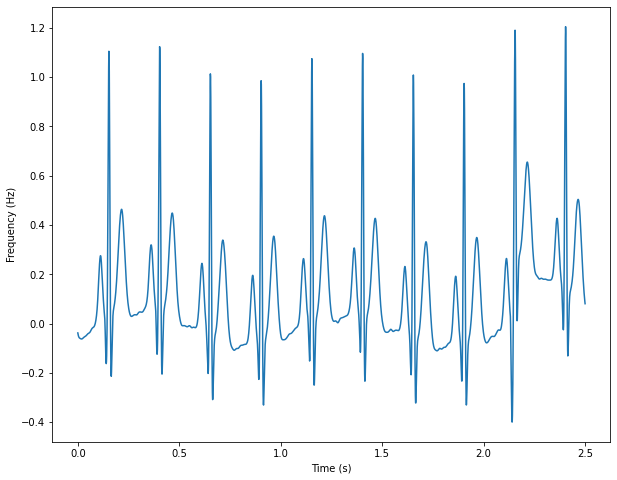

In [8]:
#%matplotlib notebook
plot_ecg_segment(zdata, params_sim['sf_int'], desired_range=[0,2500])

In [9]:
## Internal utility functions for prior generation

# Retrieves the dimension of a parameter
def get_param_dim(param_name, params_sim=None):
    if param_name in ['a', 'b', 'phi']:
        return(5)
    elif param_name == 'pos_0':
        return(3)
    elif param_name == 't_span':
        return(2)
    elif param_name == 't_eval':
        return(len(params_sim['t_eval']))
    else:
        return(1)

# Computes the number of dimensions of one prior draw (i.e. the sum of the dimensions
# of all parameters being varied)
def get_n_params(param_list, params_sim):
    n_params = 0
    for p in param_list:
        n_params += get_param_dim(p, params_sim)
    return(n_params)

# Separates parameters related to the ODE system itself from those related to simulation
def split_param_list(param_list, params_sim):
    for i in range(len(param_list)):
        if param_list[i] in params_sim.keys():
            param_list_ODE = param_list[:i]
            param_list_sim = param_list[i:]
            break
        else:
            i += 1
    
    if i == len(param_list):
        param_list_ODE = param_list
        param_list_sim = None
    
    return(param_list_ODE, param_list_sim)

## Prior generation

# Draws from the prior distribution of a single parameter (scalar or vector)
# The distribution in question is a normal distribution centered around the default value of the parameter
# with a standard deviation of 0.05
def generate_single_param_prior(parameter, deviation_mean = 0, deviation_std = 0.05):
    if isinstance(parameter, int):
        parameter = float(parameter)

    variation_coefficient = np.random.normal(deviation_mean, deviation_std)
    #output_p  = parameter + variation_coefficient
    output_p = parameter + parameter*variation_coefficient
    
    if np.ndim(output_p) == 0:
        output_p = np.array([output_p])
    
    return(output_p)


# Batched version of the above function
def generate_single_param_prior_batch(parameter, batch_size, deviation_mean = 0, deviation_std = 0.05):
    # was_int = False
    
    if isinstance(parameter, int):
        parameter = float(parameter)
    #    was_int = True
    
    variation_coefficients = np.random.normal(deviation_mean, deviation_std, batch_size)
    output_p = np.tile(parameter, (batch_size,1))
    #output_p += variation_coefficients[:, np.newaxis]
    output_p = output_p + output_p*variation_coefficients[:, np.newaxis]
        
#     if was_int:
#         output_p = np.asarray([int(output_p[i]) for i in range(len(output_p))])
    
    # Ensure that the output is an array of arrays (as opposed to an array of floats)
    if np.ndim(output_p[0]) == 0:
        output_p = np.asarray([[output_p[i]] for i in range(len(output_p))])
    
    return(output_p)

# Generates a concatenation of prior draws for all parameters being varied
def generate_ecg_parameter_prior(params_ODE, params_sim=None, deviation_mean=0, deviation_std=0.05,\
                   ODE_params_to_vary=['b','phi','f_2'], sim_params_to_vary=[]):
    
    output_list = []
    variable_list = []
    
    for p in ODE_params_to_vary:
        original_p = params_ODE[p]
        output_p = generate_single_param_prior(original_p, deviation_mean, deviation_std)
        output_list += [output_p]
    
    for p in sim_params_to_vary:
        original_p = params_sim[p]
        output_p = generate_single_param_prior(original_p, deviation_mean, deviation_std)
        output_list += [output_p]
    
    output_array=np.concatenate(output_list)
    
    return(output_array)

# Batched version of the above function
def generate_ecg_parameter_prior_batch(batch_size, params_ODE, params_sim=None, deviation_mean=0, \
                                       deviation_std=0.05, ODE_params_to_vary=['b','phi','f_2'], \
                                       sim_params_to_vary=[]):
    
    output_list = []
    variable_list = []
    
    for p in ODE_params_to_vary:
        original_p = params_ODE[p]
        output_p = generate_single_param_prior_batch(original_p, batch_size, deviation_mean, deviation_std)
        output_list += [output_p]
        #variable_list += [p]
    
    for p in sim_params_to_vary:
        original_p = params_sim[p]
        output_p = generate_single_param_prior_batch(original_p, batch_size, deviation_mean, deviation_std)
        output_list += [output_p]
        #variable_list += [p]
    
    #print("Prior generated for {}".format(variable_list))
    
    return(np.concatenate(output_list, axis=1))

# Simulates data from a single prior sample
def simulate_one(prior_sample, params_ODE, params_sim, param_list =['b', 'phi', 'f_2']): 
    
    param_list_ODE, param_list_sim = split_param_list(param_list, params_sim)
    
    output_ODE = {}
    current_index = 0
    for p in param_list_ODE:
        next_index = current_index + get_param_dim(p, params_sim)
        output_ODE[p] = prior_sample[current_index:next_index]
        current_index = next_index

    
    if param_list_sim is not None:
        sim_param_change = True
        output_sim = {}
        for q in param_list_sim:
            d = get_param_dim(q, params_sim)
            next_index = current_index + d
            if d > 1:
                output_sim[q] = prior_sample[current_index:next_index]
            else:
                output_sim[q] = prior_sample[current_index]
            current_index = next_index
    
    current_params_ODE = copy.deepcopy(params_ODE)
    current_params_sim = copy.deepcopy(params_sim)

    
    for p in param_list_ODE:
        current_params_ODE[p] = output_ODE[p]
        if sim_param_change:
            for q in param_list_sim:
                current_params_sim[q] = output_sim[q]
    _, _, z = generate_ECG(current_params_ODE, current_params_sim, params_TS = None, baseline_wander=True)
    
    return(z)

# Batched version of the above function
def simulate_batch(prior_sample, params_ODE, params_sim, param_list =['b', 'phi', 'f_2']): 
    
    param_list_ODE, param_list_sim = split_param_list(param_list, params_sim)
    
    output_ODE = {}
    current_index = 0
    for p in param_list_ODE:
        next_index = current_index + get_param_dim(p, params_sim)
        output_ODE[p] = prior_sample[:,current_index:next_index]
        current_index = next_index
    
    if param_list_sim is not None:
        sim_param_change = True
        output_sim = {}
        for q in param_list_sim:
            d = get_param_dim(q, params_sim)
            next_index = current_index + d
            if d > 1:
                output_sim[q] = prior_sample[:,current_index:next_index]
            else:
                output_sim[q] = prior_sample[:,current_index]
            current_index = next_index
    
    current_params_ODE = copy.deepcopy(params_ODE)
    current_params_sim = copy.deepcopy(params_sim)
    
    if len(param_list_ODE) > 0:
        n = output_ODE[param_list_ODE[0]].shape[0]
    else:
        n = output_sim[param_list_sim[0]].shape[0]
    
    batch = []
    
    for i in range(n):
        for p in param_list_ODE:
            current_params_ODE[p] = output_ODE[p][i]
        if sim_param_change:
            for q in param_list_sim:
                current_params_sim[q] = output_sim[q][i]
        _, _, z = generate_ECG(current_params_ODE, current_params_sim, params_TS = None, baseline_wander=True)
        batch += [z]
    
    batch = np.array(batch)
    
    return(batch)

In [10]:
ODE_params_to_vary = ['a']
sim_params_to_vary = ['heartrate_mean']
param_names = [r'a_0', r'a_1', r'a_2', r'a_3', r'a_4', r'heartrate_mean']
param_list = np.concatenate([ODE_params_to_vary, sim_params_to_vary])
n_params = get_n_params(param_list, params_sim)
print("Number of parameters: {}".format(n_params))

Number of parameters: 6


In [11]:
###
###
# Generate a batch of 1000 prior draws in order to create a rudimentary visualization of the prior below
###
###
my_prior = generate_ecg_parameter_prior_batch(1000, params_ODE, params_sim, \
                                        ODE_params_to_vary = ODE_params_to_vary, \
                                        sim_params_to_vary= sim_params_to_vary)
my_prior.shape

(1000, 6)

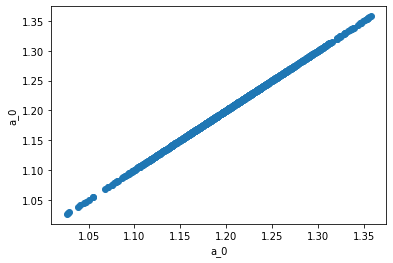

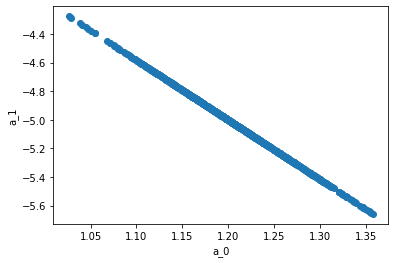

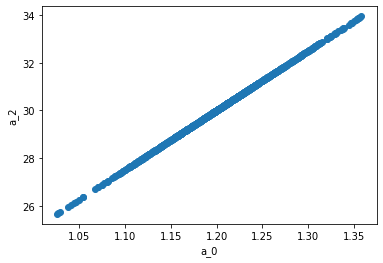

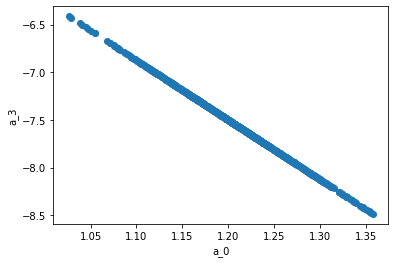

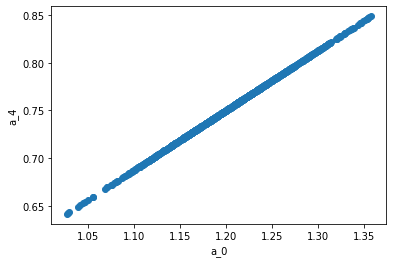

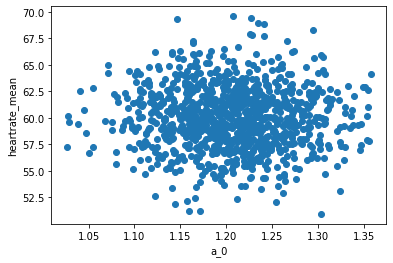

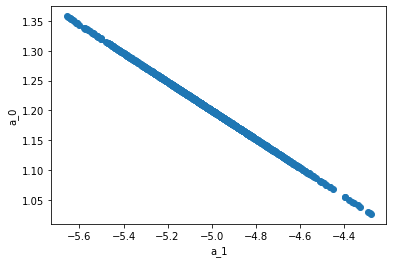

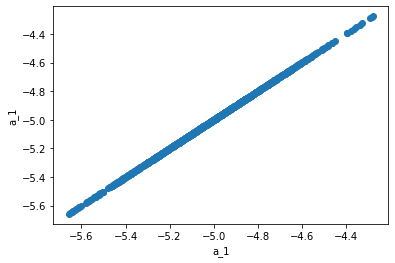

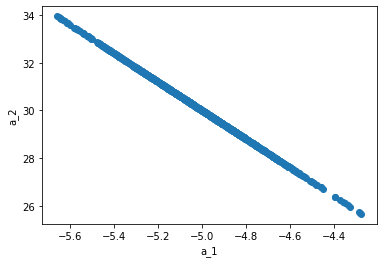

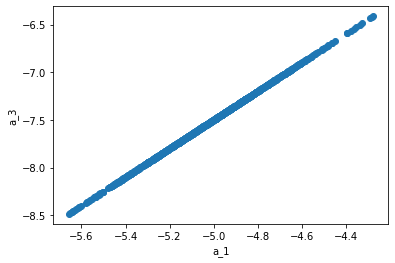

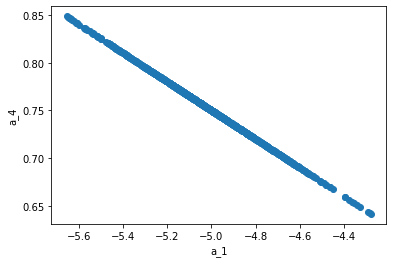

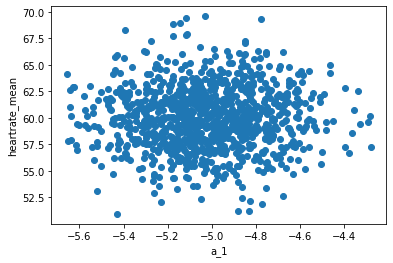

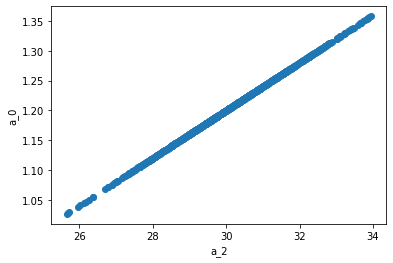

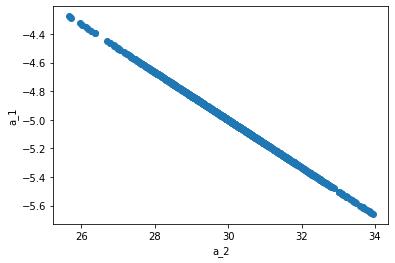

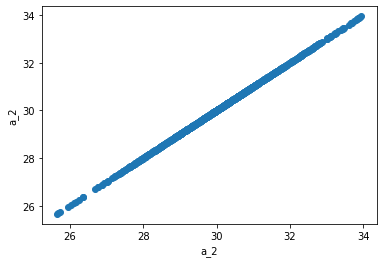

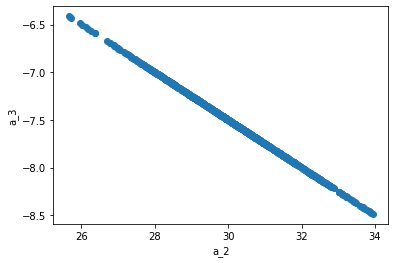

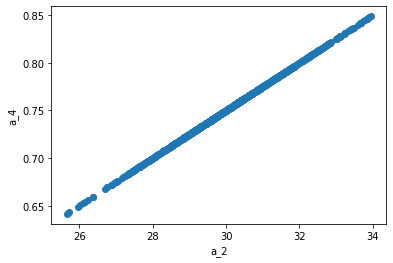

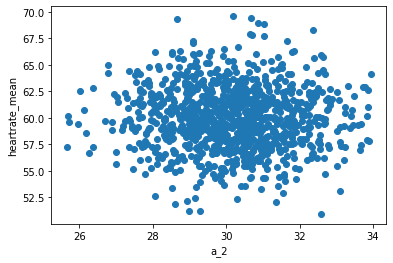

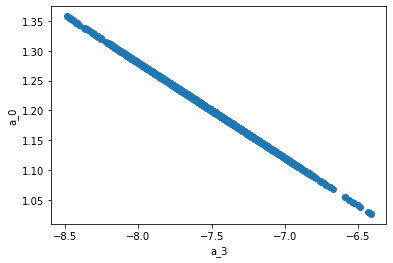

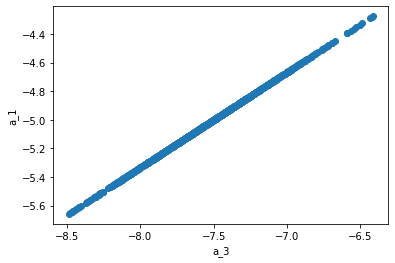

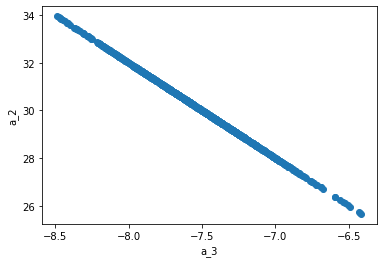

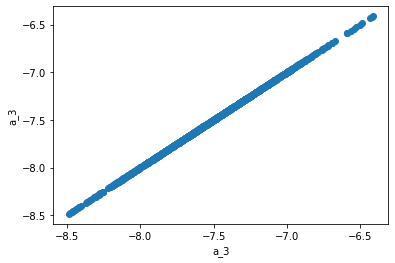

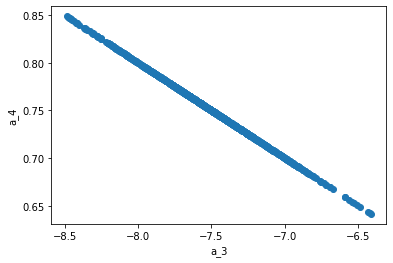

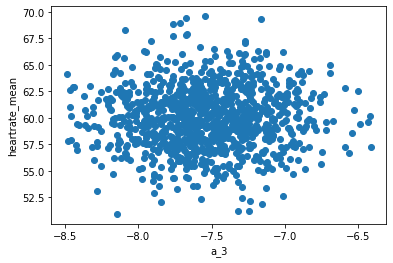

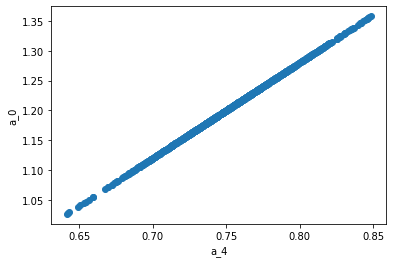

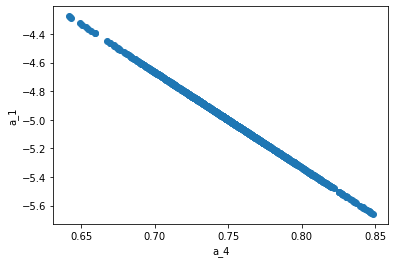

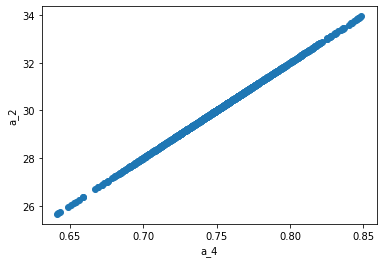

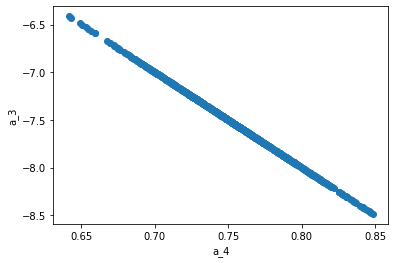

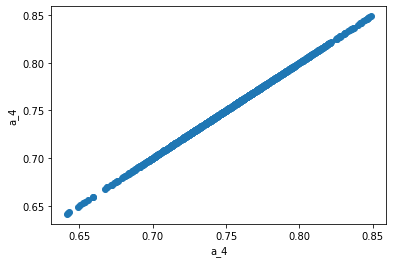

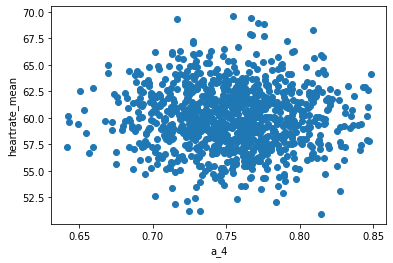

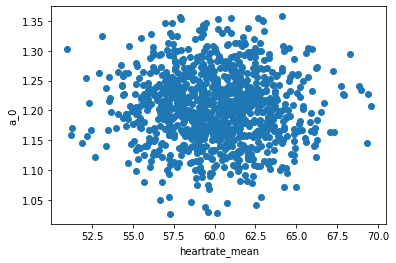

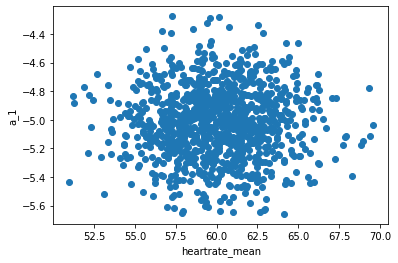

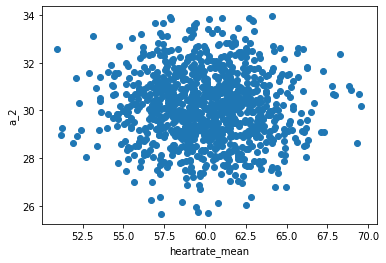

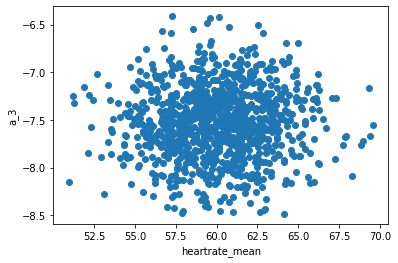

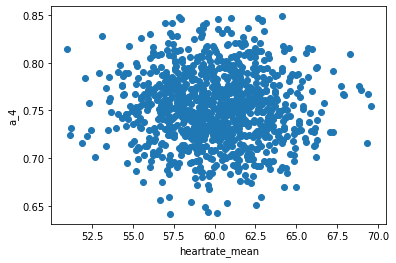

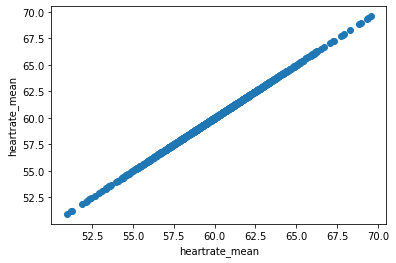

In [12]:
###
###
# Rudimentarily visualize the prior
###
###

for i in range(n_params):
    for j in range(n_params):
        plt.xlabel(param_names[i])
        plt.ylabel(param_names[j])
        plt.scatter(my_prior[:,i], my_prior[:,j], label=[i,j])
        plt.show()

In [13]:
# my_batch = simulate_batch(my_prior, params_ODE, params_sim, param_list = param_list)
# my_batch.shape

In [14]:
prior_ecg = Prior(prior_fun=partial(generate_ecg_parameter_prior, params_ODE=params_ODE, params_sim=params_sim, \
                                ODE_params_to_vary=ODE_params_to_vary, \
                                sim_params_to_vary=sim_params_to_vary),\
              param_names=param_names
)
# prior_ecg = Prior(batch_prior_fun = partial(generate_ecg_parameter_prior_batch, params_ODE=params_ODE, \
#                                             params_sim=params_sim, ODE_params_to_vary=ODE_params_to_vary, \
#                                             sim_params_to_vary=sim_params_to_vary),\
#                   param_names=param_names
# )

# simulator = Simulator(
#     simulator_fun=partial(simulate_one, params_ODE=params_ODE, params_sim=params_sim,\
#                           param_list=['b', 'heartrate_mean'])
# )
simulator_ecg = Simulator(
    batch_simulator_fun=partial(simulate_batch, params_ODE=params_ODE, params_sim=params_sim,\
                          param_list=param_list)
)

In [15]:
prior_means, prior_stds = prior_ecg.estimate_means_and_stds()

In [16]:
model_ecg = GenerativeModel(prior_ecg, simulator_ecg, name='basic_ecg_simulator')

INFO:root:Performing 2 pilot runs with the basic_ecg_simulator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 7500)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


LinAlgError: 2-th leading minor of the array is not positive definite

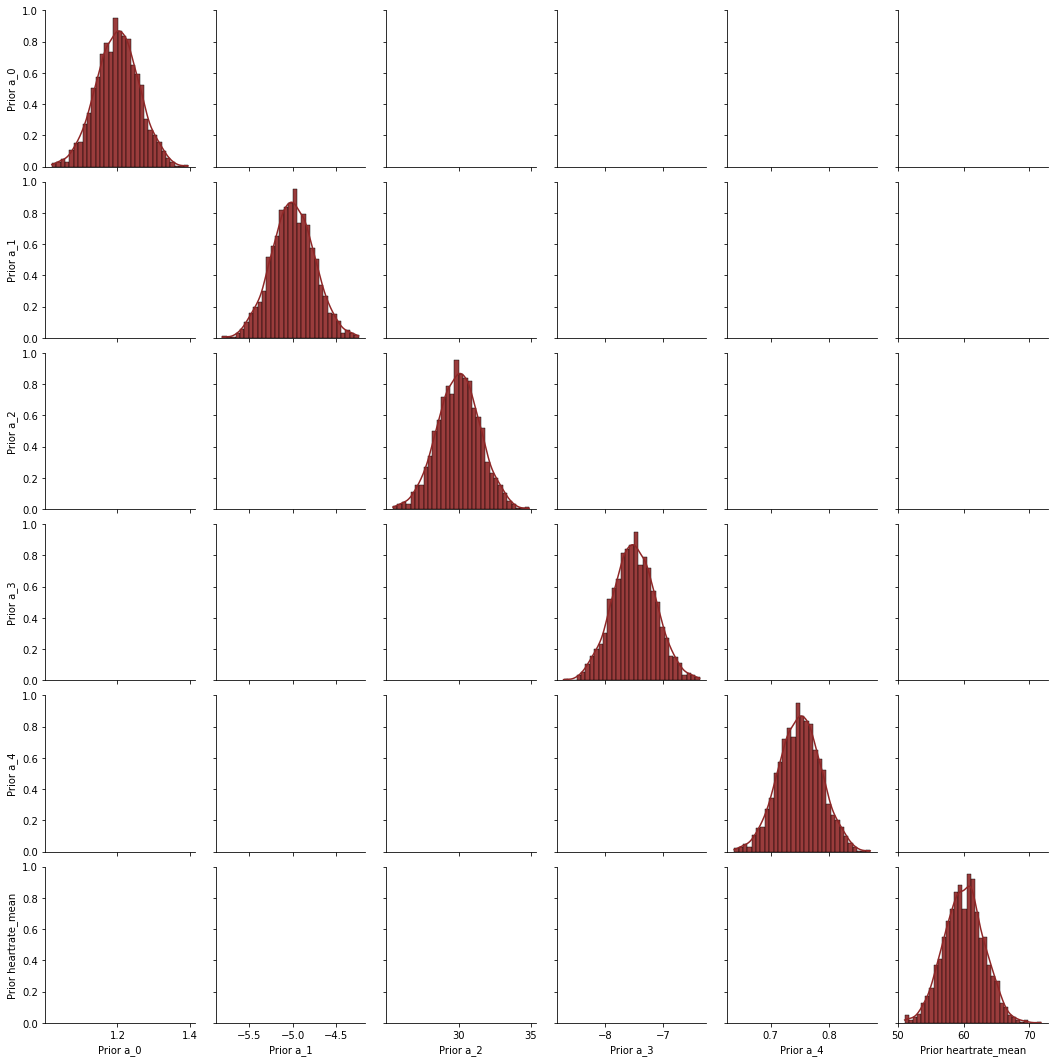

In [17]:
#As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
f = prior_ecg.plot_prior2d()

In [24]:
####
####
# To test prior behavior, run all cells above this one!
####
####

In [25]:
class NN_ecg(tf.keras.Model):
    def __init__(self, n_summary, sampling_frequency):
        super(NN_ecg, self).__init__()
        
        self.conv =  tf.keras.Sequential([
            tf.keras.layers.Conv1D(n_summary, kernel_size=sampling_frequency, strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Conv1D(n_summary*2, kernel_size=int(sampling_frequency/2), strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Conv1D(n_summary*3, kernel_size=int(sampling_frequency/3), strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform')
        ])
        self.lstm = tf.keras.layers.LSTM(n_summary)

    def call(self, x, **args):
        """x is a 3D tensor of shape (batch_size, n_time_steps, n_time_series)"""

        out = self.conv(x)
        out = self.lstm(out)
        return out


# class NN_ecg(tf.keras.Model):
#     def __init__(self, n_summary, sampling_frequency):
#         super(NN_ecg, self).__init__()
        
#         self.conv =  tf.keras.Sequential([
# #             tf.keras.layers.Conv1D(n_summary, kernel_size=sampling_frequency, strides=1,
#             tf.keras.layers.Conv1D(sampling_frequency, kernel_size=sampling_frequency, strides=1, 
#                                    padding='causal', activation='relu'),
#             tf.keras.layers.MaxPooling1D(),
# #             tf.keras.layers.Conv1D(n_summary*2, kernel_size=int(sampling_frequency/2), strides=1,
#             tf.keras.layers.Conv1D(int(sampling_frequency/2), kernel_size=int(sampling_frequency/2), strides=1, 
#                                    padding='causal', activation='relu'),
#             tf.keras.layers.MaxPooling1D(),
# #             tf.keras.layers.Conv1D(n_summary*3, kernel_size=int(sampling_frequency/3), strides=1, 
#             tf.keras.layers.Conv1D(int(sampling_frequency/4), kernel_size=int(sampling_frequency/4), strides=1, 
#                                    padding='causal', activation='relu'),
#             tf.keras.layers.MaxPooling1D(),
#             tf.keras.layers.Dense(n_summary)
#         ])
# #        self.full = tf.keras.layers.Dense(n_summary)
# #        self.lstm = tf.keras.layers.LSTM(n_summary)
# #         self.conv = tf.keras.layers.Conv1D(n_summary, kernel_size=sampling_frequency, strides=1,
# #                                    padding='causal', activation='relu', kernel_initializer='glorot_uniform')
# #         self.lstm = tf.keras.Sequential([
# #             tf.keras.layers.LSTM(n_summary, return_sequences=True),
# #             tf.keras.layers.LSTM(n_summary, return_sequences=True),
# #             tf.keras.layers.LSTM(n_summary)])

#     def call(self, x, **args):
#         """x is a 3D tensor of shape (batch_size, n_time_steps, n_time_series)"""

#         out = self.conv(x)
#         #out = self.full(out)
#         #out = self.lstm(x)
#         return out

In [26]:
summary_net_ecg = NN_ecg(n_summary=16, sampling_frequency=params_sim['sf_ecg'])
inference_net_ecg = InvertibleNetwork({
    'n_params': n_params, 
    'n_coupling_layers': 8, 
})

2022-08-31 13:27:44.033517: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-31 13:27:44.034176: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [27]:
#summary_net_ecg(my_batch)

In [28]:
amortizer_ecg = AmortizedPosterior(inference_net_ecg, summary_net_ecg, name='ecg_amortizer')

In [29]:
def configurator_ecg(forward_dict):
    # Prepare placeholder dict
    out_dict = {}
    
    # Reshape data to (batch size, signal length, 1) and cast data to float32
    # GPUs are optimized for float32 computations, and convolutional NN require
    # the number of channels as a third dimension - this is 1 for the ECG signal
    simdata = forward_dict['sim_data']
    simdata = np.expand_dims(simdata, axis=2)
    flt32data = simdata.astype(np.float32)
    
    # Cast parameters to float32
    ### (Extract prior draws and z-standardize with previously computed means)
    params = forward_dict['prior_draws'].astype(np.float32)
    # Test normalization:
    params = (params - prior_means) / prior_stds
    
    # Remove a batch if it contains nan, inf or -inf
    idx_keep = np.all(np.isfinite(flt32data), axis=(1, 2))
    if not np.all(idx_keep):
        print('Invalid value encountered...removing from batch')
    
    # Add to keys
    out_dict['summary_conditions'] = flt32data[idx_keep]
    out_dict['parameters'] = params[idx_keep]
    
    return out_dict    

In [30]:

trainer_ecg = Trainer(amortizer=amortizer_ecg, generative_model=model_ecg, configurator=configurator_ecg, \
                      checkpoint_path='/home/rene/BayesFlow/docs/source/tutorial_notebooks/checkpoints_Aug30')

INFO:root:Networks loaded from /home/rene/BayesFlow/docs/source/tutorial_notebooks/checkpoints_Aug30/ckpt-16
INFO:root:Performing a consistency check with provided components...


Loaded loss history from /home/rene/BayesFlow/docs/source/tutorial_notebooks/checkpoints_Aug30/history_16.pkl
Loaded simulation memory from /home/rene/BayesFlow/docs/source/tutorial_notebooks/checkpoints_Aug30/memory_16.pkl


INFO:root:Done.


In [31]:
amortizer_ecg.summary()

Model: "ecg_amortizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
invertible_network (Invertib multiple                  180512    
_________________________________________________________________
nn_ecg (NN_ecg)              multiple                  199744    
Total params: 380,256
Trainable params: 380,160
Non-trainable params: 96
_________________________________________________________________


In [31]:
#trainer_ecg.train_online(50,1,1)

Training epoch 1: 100%|█| 1/1 [00:06<00:00,  6.97s/it, Epoch: 1, Iter: 1,Loss: 1
Training epoch 2: 100%|█| 1/1 [00:06<00:00,  6.33s/it, Epoch: 2, Iter: 1,Loss: 3
Training epoch 3: 100%|█| 1/1 [00:06<00:00,  6.38s/it, Epoch: 3, Iter: 1,Loss: 2
Training epoch 4: 100%|█| 1/1 [00:06<00:00,  6.32s/it, Epoch: 4, Iter: 1,Loss: 1
Training epoch 5: 100%|█| 1/1 [00:06<00:00,  6.49s/it, Epoch: 5, Iter: 1,Loss: 1
Training epoch 6: 100%|█| 1/1 [00:09<00:00,  9.05s/it, Epoch: 6, Iter: 1,Loss: 1
Training epoch 7: 100%|█| 1/1 [00:08<00:00,  8.82s/it, Epoch: 7, Iter: 1,Loss: 0
Training epoch 8: 100%|█| 1/1 [00:08<00:00,  8.86s/it, Epoch: 8, Iter: 1,Loss: 0
Training epoch 9: 100%|█| 1/1 [00:08<00:00,  8.85s/it, Epoch: 9, Iter: 1,Loss: -
Training epoch 10: 100%|█| 1/1 [00:08<00:00,  8.81s/it, Epoch: 10, Iter: 1,Loss:
Training epoch 11: 100%|█| 1/1 [00:08<00:00,  8.83s/it, Epoch: 11, Iter: 1,Loss:
Training epoch 12: 100%|█| 1/1 [00:08<00:00,  9.00s/it, Epoch: 12, Iter: 1,Loss:
Training epoch 13: 100%|█| 1

In [ ]:
# trainer_ecg.checkpoint = tf.train.Checkpoint(optimizer=trainer_ecg.optimizer, model=trainer_ecg.amortizer)
# trainer_ecg.manager = \
# tf.train.CheckpointManager(trainer_ecg.checkpoint,\
#                            '/home/rene/BayesFlow/docs/source/tutorial_notebooks/checkpoints', max_to_keep=10)
# trainer_ecg.checkpoint.restore(trainer_ecg.manager.latest_checkpoint)

In [32]:
losses = trainer_ecg.loss_history.get_plottable()

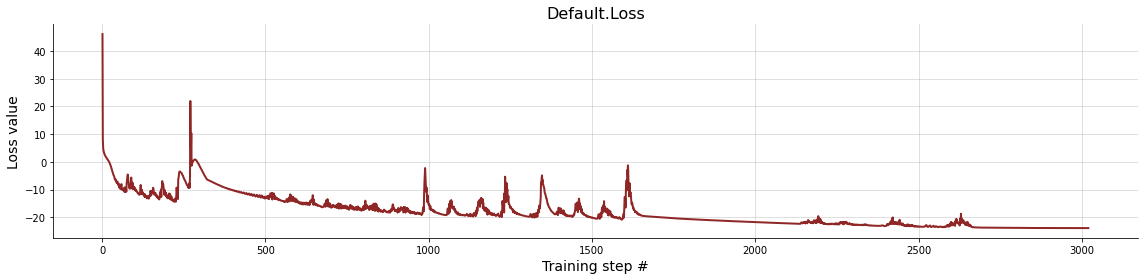

In [33]:
fig = diag.plot_losses(losses)

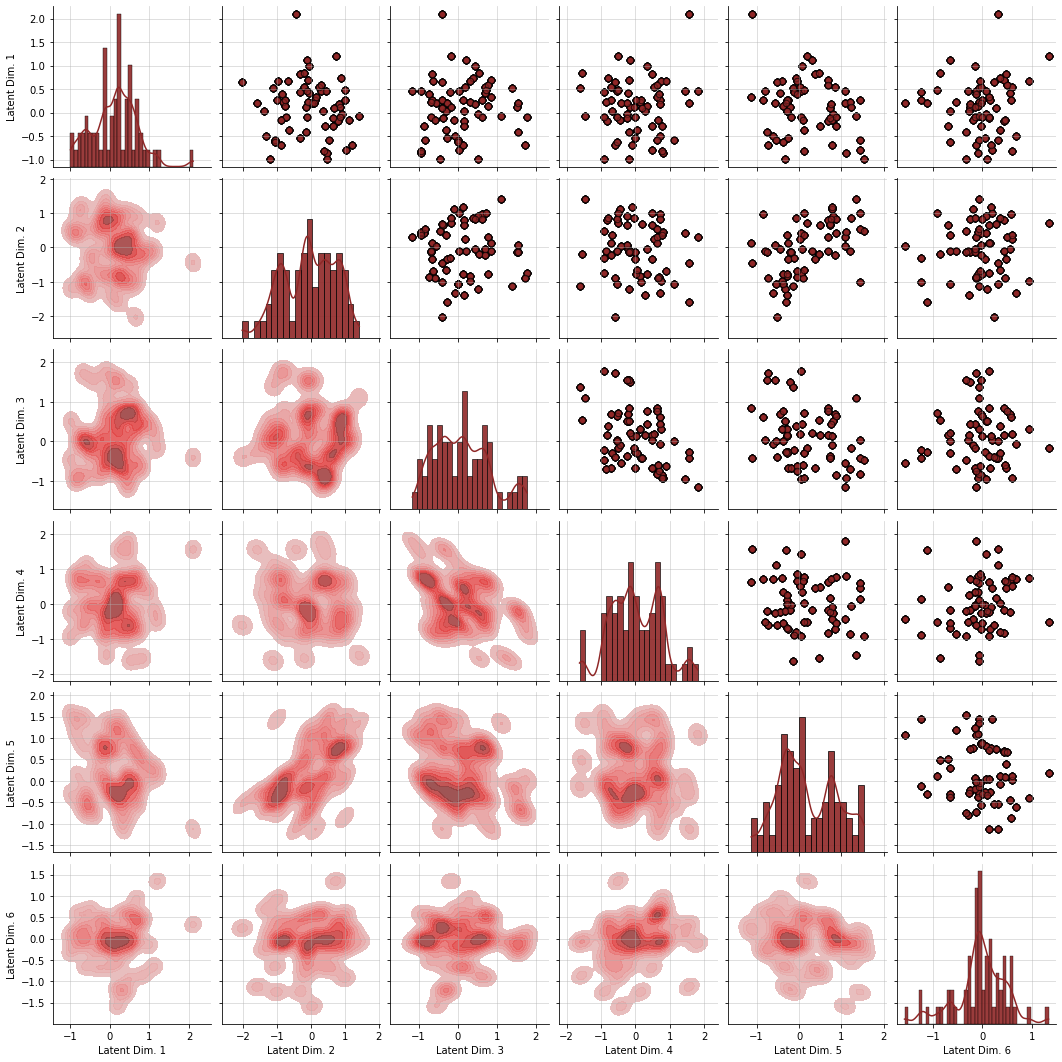

In [34]:
fig_2 = trainer_ecg.diagnose_latent2d()

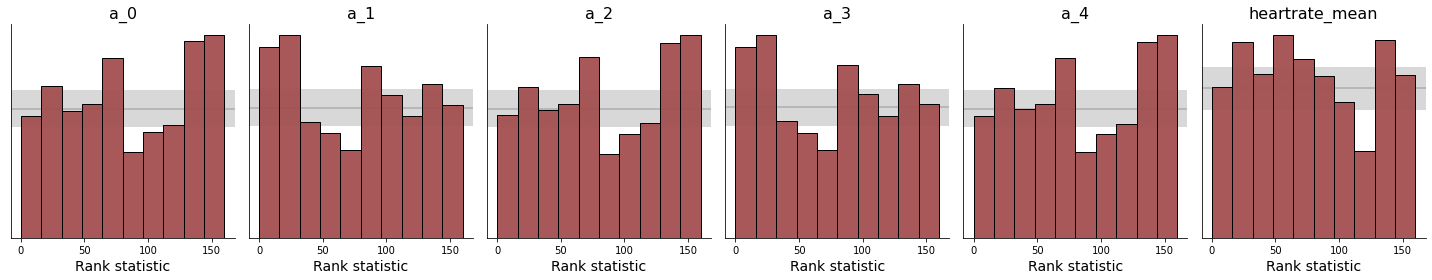

In [35]:
fig = trainer_ecg.diagnose_sbc_histograms()

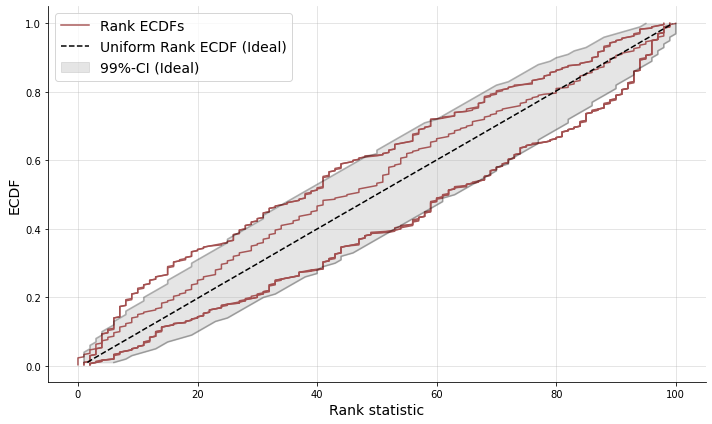

In [36]:
valid_sim_data_raw = model_ecg(batch_size=300)
valid_sim_data = trainer_ecg.configurator(valid_sim_data_raw)
posterior_samples = amortizer_ecg.sample(valid_sim_data, n_samples=100)
fig = diag.plot_sbc_ecdf(posterior_samples, valid_sim_data['parameters'])

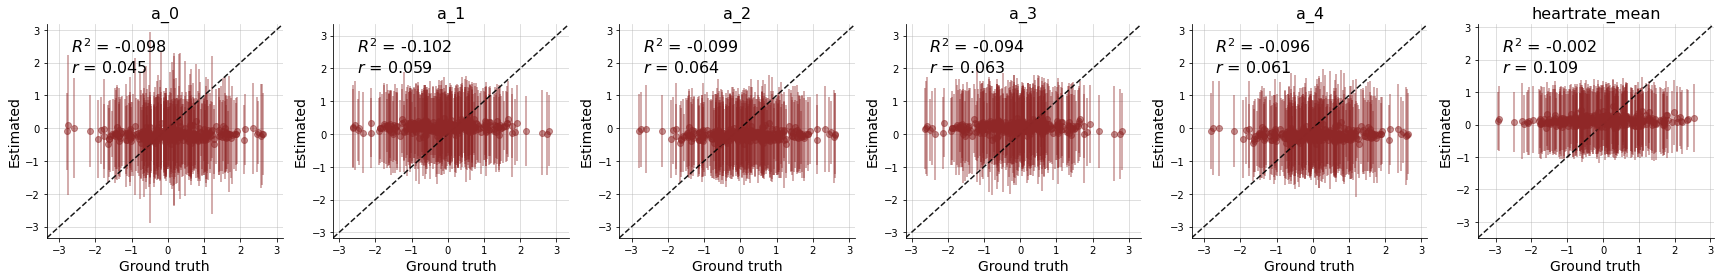

In [37]:
fig = diag.plot_recovery(posterior_samples, valid_sim_data['parameters'], param_names=prior_ecg.param_names)

In [ ]:
posterior_samples_unnorm = prior_means + posterior_samples * prior_stds
fig = diag.plot_posterior_2d(posterior_samples_unnorm[0], param_names=prior.param_names)

In [ ]:
fig = diag.plot_posterior_2d(posterior_samples_unnorm[0], prior=prior)

In [ ]:
# re-simulation
resim_u = np.empty((posterior_samples_unnorm[0].shape[0], len(time_points)), dtype=np.float32)
resim_v = np.empty((posterior_samples_unnorm[0].shape[0], len(time_points)), dtype=np.float32)

for i in range(posterior_samples_unnorm[0].shape[0]):
    re_sim = linear_ode_solver(posterior_samples_unnorm[0, i], time_points)
    resim_u[i, :] = re_sim[:, 0]
    resim_v[i, :] = re_sim[:, 1]

# compute quantiles
u_qt_50 = np.quantile(resim_u, q=[0.25, 0.75], axis=0)
u_qt_90 = np.quantile(resim_u, q=[0.05, 0.95], axis=0)
u_qt_95 = np.quantile(resim_u, q=[0.025, 0.975], axis=0)
v_qt_50 = np.quantile(resim_v, q=[0.25, 0.75], axis=0)
v_qt_90 = np.quantile(resim_v, q=[0.05, 0.95], axis=0)
v_qt_95 = np.quantile(resim_v, q=[0.025, 0.975], axis=0)
    
# plot u
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(time_points, np.median(resim_u, axis=0), label='Median u(t)', color='b')
ax.plot(time_points, valid_sim_data_raw['sim_data'][0, :, 0], marker='o', label='Ground truth u(t)', color='k', linestyle='--', alpha=0.8)
ax.fill_between(time_points, u_qt_50[0], u_qt_50[1], color='b', alpha=0.3, label='50% CI')
ax.fill_between(time_points, u_qt_90[0], u_qt_90[1], color='b', alpha=0.2, label='90% CI')
ax.fill_between(time_points, u_qt_95[0], u_qt_95[1], color='b', alpha=0.1, label='95% CI')
ax.grid(True)
ax.set_title("Re-simulation for u(t)")
ax.set_xlabel("Time t [s]")
ax.set_ylabel("Function u(t)")
ax.legend()
plt.show()

# plot v
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(time_points, np.median(resim_v, axis=0), label='Median v(t)', color='b')
ax.plot(time_points, valid_sim_data_raw['sim_data'][0, :, 1], marker='o', label='Ground truth v(t)', color='k', linestyle='--', alpha=0.8)
ax.fill_between(time_points, v_qt_50[0], v_qt_50[1], color='b', alpha=0.3, label='50% CI')
ax.fill_between(time_points, v_qt_90[0], v_qt_90[1], color='b', alpha=0.2, label='90% CI')
ax.fill_between(time_points, v_qt_95[0], v_qt_95[1], color='b', alpha=0.1, label='95% CI')
ax.grid(True)
ax.set_title("Re-simulation for v(t)")
ax.set_xlabel("Time t [s]")
ax.set_ylabel("Function v(t)")
ax.legend()
plt.show()

In [ ]:
## Offene Fragen
# 1. Welche Parameter sollten variiert werdden (b,phi,a,f_2, Simulation)?
# 2. Wie sollte variiert werden (Verteilung, Streuung)?
# Ziel: Zunächst einmal gesunde Fälle priorisieren. Ggf. mehrere Modelle nutzen (unterschiedliche Pathologien)
# -> Model selection
# Einheit für Periode gleich halten (gleiche Zeitschrittgröße); Signallänge (/Anzahl der Perioden)
# erstmal fix mit CNN, dann mit LSTM variabel

# Weiß man, wie hoch die Rauschamplitude ist? Wenn ja, als Parameter an das NN übergeben

# Kalibrierungsproblemerklärung: zu wenig trainiert, zu kleines Netz